In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List

# Dataset

In [56]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    dataframe = pandas.read_csv(path_to_csv, header=1)
    dataframe = dataframe.sample(frac = 1)
    data_list = dataframe.values.tolist()
    y = np.array([0 if i[0]=='B' else 1 for i in data_list], dtype=np.int8)
    X = np.array([i[1:] for i in data_list])
    return X, y


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    dataframe = pandas.read_csv(path_to_csv, header=1)
    dataframe = dataframe.sample(frac = 1)
    data_list = dataframe.values.tolist()
    y = np.array([i[-1] for i in data_list], dtype=np.int8)
    X = np.array([i[:-1] for i in data_list])
    return X, y

In [57]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    
    train_count = round(y.shape[0] * ratio)
    X_train = X[:train_count + 1]
    y_train = y[:train_count + 1]
    X_test = X[train_count + 1:]
    y_test = y[train_count + 1:]
    return  X_train, y_train, X_test, y_test

# Precision_Recall_Accuracy

In [58]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:

    count_of_elements = y_pred.shape[0]
    lbs = np.unique(y_true)

    precision = np.array([])
    recall = np.array([])
    TP = 0

    for lb in lbs:
    
        TP_lb = np.sum((y_true == lb) & (y_pred == lb))
        TN_lb = np.sum((y_true != lb) & (y_pred != lb))
        FP_lb = np.sum((y_true != lb) & (y_pred == lb))
        FN_lb = np.sum((y_true == lb) & (y_pred != lb))
        
        precision_lb = 0 if TP_lb == 0 else TP_lb / (TP_lb + FP_lb)
        recall_lb = 0 if TP_lb == 0 else TP_lb / (TP_lb + FN_lb)
        
        precision = np.append(precision, precision_lb)
        recall = np.append(recall, recall_lb)
        
        TP += TP_lb
    
    accuracy = TP / count_of_elements
    
    return precision, recall, float(accuracy)

In [59]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

In [60]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

# KDTree

In [61]:
class Leaf():
    def __init__(self, points):
        self.points = points

In [62]:
class Node():
    def __init__(self, feature, median, left_child, right_child): 
        self.feature = feature
        self.median = median
        self.left_child = left_child
        self.right_child = right_child

In [63]:
class KDTree:   
    def __init__(self, X: np.array, leaf_size: int = 40):
        self.leaf_size = leaf_size
        self.elements_count = X.shape[0]
        self.features_count = X.shape[1] + 1
       
        indices = np.linspace(0, X.shape[0] - 1, X.shape[0])
        pt_data = np.column_stack((indices, X))
        
        if self.elements_count <= self.leaf_size:
            self.root = Leaf(pt_data)
        else:
            self.root = self.build_tree(pt_data)
              
      
    def build_tree(self, pt_data, feature=1):
        minimum = 0
        count = 1
        
        # проход по признакам
        while count < self.features_count and minimum < self.leaf_size:
            median = np.median(pt_data[:,feature])
            left_part = pt_data[pt_data[:,feature] < median]      
            right_part = pt_data[pt_data[:,feature] >= median]  
            minimum = min(left_part.shape[0], right_part.shape[0])
            count += 1
            orig_feature = feature
            if feature == self.features_count - 1:
                feature = 1
            else:
                feature += 1

        if count >= self.features_count:
            return Leaf(pt_data)
        
        else:
            left_child = self.build_tree(left_part, feature)
            right_child = self.build_tree(right_part, feature)
            return Node(orig_feature, median, left_child, right_child)     
              
        
    def query(self, X: np.array, k: int = 1) -> List[List]:
        self.k = k
        tree = self.root
        
        index_distance = [self.search(i, tree) for i in X]
        without_distance = [[int(i[1]) for i in j] for j in index_distance]
        return without_distance
    
    
    def search(self, point, curr_node):
        
        # если узел
        if isinstance(curr_node, Node):
        
            # левее или правее медианы
            if point[curr_node.feature - 1] < curr_node.median:
                array1 = self.search(point, curr_node.left_child)
                flag = 'left'
            else:
                array1 = self.search(point, curr_node.right_child)
                flag = 'right'
            
            # расст до медианы и дальнего соседа
            median_dist = np.linalg.norm(point[curr_node.feature - 1] - curr_node.median)
            farest_neighbour_dist = array1[-1][0]
            
            # если до медианы ближе
            if farest_neighbour_dist >= median_dist:
                array2 = self.search(point, curr_node.right_child if flag == 'left' else curr_node.left_child)
                array = self.mergesort(array1, array2)
                array = array[:self.k]
            else:
                array = array1
            
        # если лист
        else:
            array = [[np.linalg.norm(point - i[1:]), i[0]] for i in curr_node.points]
            array.sort()
            array = array[:self.k]        
        
        return array
    
    
    def mergesort(self, array1, array2):
        ans = []
        n = len(array1)
        m = len(array2)
        i = 0
        j = 0
        while i < n and j < m:
            if array1[i] < array2[j]:
                ans.append(array1[i])
                i += 1
            else:
                ans.append(array2[j])
                j += 1
        ans.extend(array1[i:])
        ans.extend(array2[j:])
        return ans

test

In [66]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

# KNearest

In [67]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):       
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:       
        self.y = y
        self.mean = np.array([np.mean(X[:,i]) for i in range(X.shape[1])])
        self.stdev = np.array([np.std(X_test[:,i]) for i in range(X_test.shape[1])])
        dataset_train = (X - self.mean) / self.stdev
        self.tree = KDTree(dataset_train, self.leaf_size) # построить дерево

        
    def predict_proba(self, X: np.array) -> List[np.array]:
        dataset_test = (X - self.mean) / self.stdev
        neighbors = self.tree.query(dataset_test, self.n_neighbors)
        labels = self.y[neighbors]
        unique_labels = np.unique(labels)
        
        likelihood = np.empty(shape=(X.shape[0], unique_labels.shape[0]))
        for i, label in enumerate(unique_labels):
            likelihood[:, i] = np.sum(labels == label, axis = 1)
                        
        return likelihood / self.n_neighbors
    
        
    def predict(self, X: np.array) -> np.array:
        return np.argmax(self.predict_proba(X), axis=1)

# Test

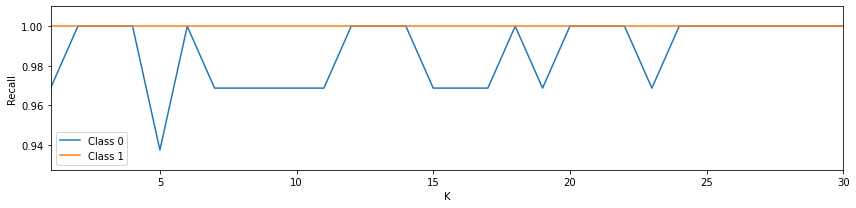

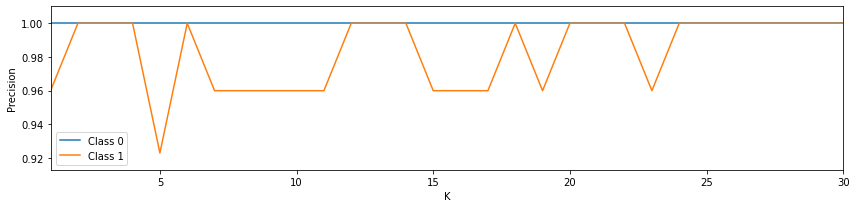

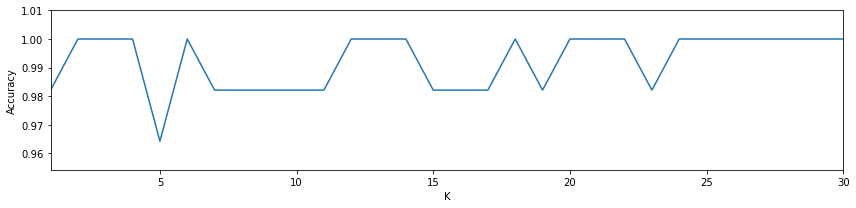

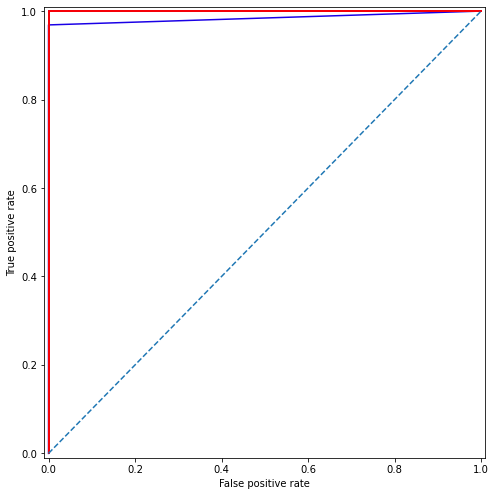

In [70]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

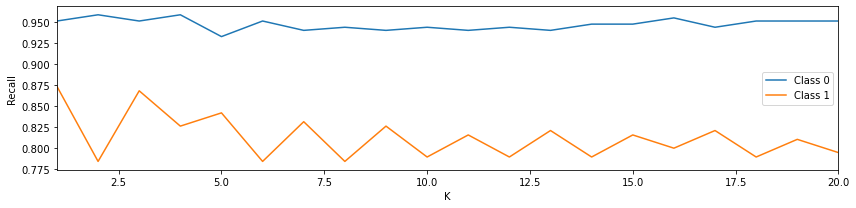

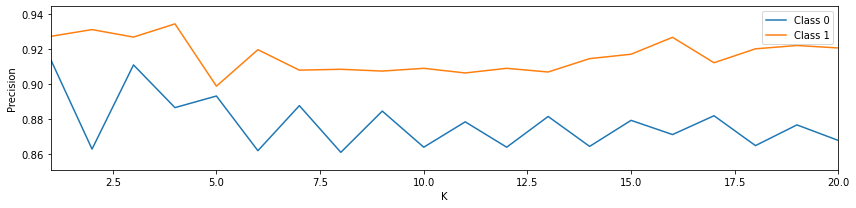

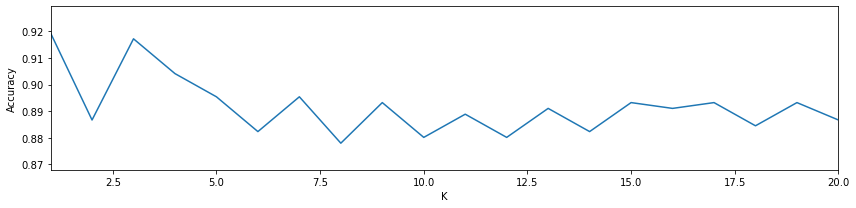

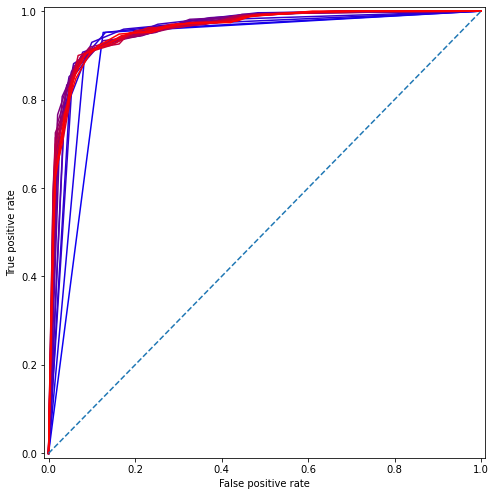

In [71]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)